In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
df = pd.read_csv('Support.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [3]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,champion_name
0,99,2,4,33,0,1,11761,3071,1526,10766,10820,14,6,75,61,Lux
1,43,6,8,8,2,1,19492,8364,5598,22012,11983,14,2,21,40,Karma
2,43,2,4,3,0,1,13859,148,66,19277,7891,13,1,14,29,Karma
3,43,4,2,10,3,1,19515,10652,6598,18308,12140,16,7,14,25,Karma
4,43,5,8,9,2,1,15718,1316,1122,20207,9770,14,3,26,35,Karma


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [4]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [5]:
lane = lane.groupby("Champion").mean()

In [6]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
3,2.955774,5.321867,10.248157,1.331695,1.063882,9773.194103,2774.405405,1458.051597,17783.176904,8087.100737,12.299754,5.643735,37.491400,29.429975
12,1.704505,5.410811,11.908108,0.603604,0.792793,5983.135135,1669.266667,1000.378378,17984.720721,6836.800000,11.385586,6.407207,41.654054,34.345946
16,0.967410,5.013722,11.634648,0.310463,0.583190,5726.711835,1668.466552,983.989708,11109.576329,6873.145798,11.349914,4.850772,41.053173,31.485420
25,2.363384,5.092233,11.450763,1.023578,0.943828,9333.211512,2408.154646,1187.998613,13452.233010,7987.877254,11.931345,5.474341,44.571429,41.657420
26,2.204668,4.416517,11.034111,1.053860,0.881508,9358.495512,2416.035907,1165.667864,13534.854578,7829.188510,12.601436,4.750449,38.784560,21.432675


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

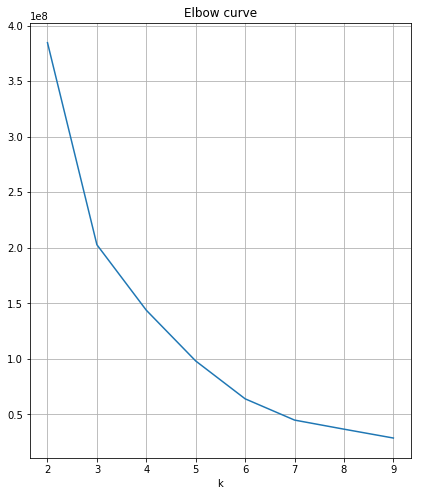

In [7]:
distorsions = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(lane)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [8]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(lane)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

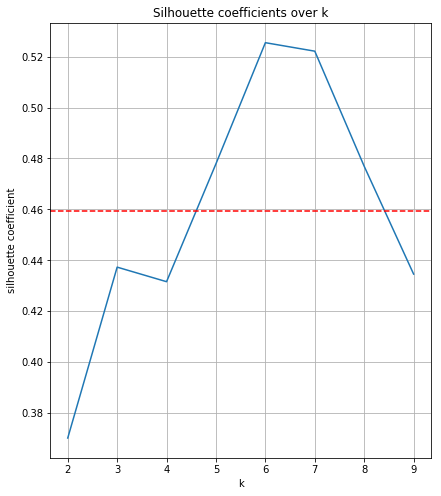

In [9]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

The highest point, which also happens to be the second "elbow" is at 6 clusters and so I will use that to further analyze the playstyles in the bot lane.

In [10]:
k_means = KMeans(n_clusters = 6).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [11]:
cluster_assignments

array([4, 0, 2, 5, 5, 5, 2, 5, 0, 0, 3, 0, 1, 0, 2, 3, 3, 0, 4, 2, 1, 0,
       5, 2, 4], dtype=int32)

In [12]:
clustered = lane.groupby('Champion').mean()

In [13]:
clustered['Cluster'] = cluster_assignments

In [14]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0    7
1    2
2    5
3    3
4    3
5    5
Name: Kills, dtype: int64

There are 5 champions in Cluster 0, 4 champions in cluster 1, 6 champions in cluster 2, and ONLY 1 champion in cluster 3. 

In [15]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,1.853969,5.238813,11.566017,0.704685,0.839942,6231.032347,2236.475966,1122.256642,16421.240084,7162.954731,11.573433,5.668933,42.330279,30.183278
1,2.560933,4.172873,12.293640,1.237913,0.950866,10720.494279,2471.241655,1462.619887,8736.166845,7951.998249,11.903023,5.367337,41.326741,30.265437
2,1.604471,4.699782,12.157401,0.634914,0.778886,6373.413516,2223.032352,1334.309389,11169.305367,7239.566570,11.521752,5.280607,43.823725,24.258806
3,4.197331,5.578145,8.172262,1.911815,1.201926,16977.687586,4981.125513,1772.389211,13769.365245,9130.979617,12.633244,4.030926,38.329967,23.648580
4,4.054454,5.021790,8.750155,1.962211,1.196708,10093.758077,2939.176175,1552.844720,19841.807343,8487.266976,12.387180,4.665529,35.693885,24.395265
5,2.502283,5.018259,11.251080,1.124794,0.943582,10082.488508,2901.187193,1453.108665,13327.860139,7983.845713,12.066077,4.918795,42.450488,23.943831


# Based on the average values of the clusters above, it looks like the one champion in Cluster 2 had an outlier performance where the values are drastically different from every other cluster.

In [16]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [26]:
clustered[clustered['Cluster'] == 5]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
25,2.363384,5.092233,11.450763,1.023578,0.943828,9333.211512,2408.154646,1187.998613,13452.233010,7987.877254,11.931345,5.474341,44.571429,41.657420,5,Morgana
26,2.204668,4.416517,11.034111,1.053860,0.881508,9358.495512,2416.035907,1165.667864,13534.854578,7829.188510,12.601436,4.750449,38.784560,21.432675,5,Zilean
37,2.566434,5.386523,11.482517,1.137953,0.967578,10396.707565,4024.583598,2231.440559,12399.006993,8217.424666,11.788938,3.475524,40.492689,10.744437,5,Sona
43,2.561138,4.758774,10.652383,1.210196,0.971555,11118.894348,3330.364241,1731.689324,12721.750646,8194.501293,12.154414,5.007019,38.602143,20.852235,5,Karma
432,2.815789,5.437247,11.635628,1.198381,0.953441,10205.133603,2326.797571,948.746964,14531.455466,7690.236842,11.854251,5.886640,49.801619,25.032389,5,Bard


# 

In [27]:
clustered.groupby('Cluster').mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,1.853969,5.238813,11.566017,0.704685,0.839942,6231.032347,2236.475966,1122.256642,16421.240084,7162.954731,11.573433,5.668933,42.330279,30.183278
1,2.560933,4.172873,12.293640,1.237913,0.950866,10720.494279,2471.241655,1462.619887,8736.166845,7951.998249,11.903023,5.367337,41.326741,30.265437
2,1.604471,4.699782,12.157401,0.634914,0.778886,6373.413516,2223.032352,1334.309389,11169.305367,7239.566570,11.521752,5.280607,43.823725,24.258806
3,4.197331,5.578145,8.172262,1.911815,1.201926,16977.687586,4981.125513,1772.389211,13769.365245,9130.979617,12.633244,4.030926,38.329967,23.648580
4,4.054454,5.021790,8.750155,1.962211,1.196708,10093.758077,2939.176175,1552.844720,19841.807343,8487.266976,12.387180,4.665529,35.693885,24.395265
5,2.502283,5.018259,11.251080,1.124794,0.943582,10082.488508,2901.187193,1453.108665,13327.860139,7983.845713,12.066077,4.918795,42.450488,23.943831
